In [27]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Shape of S: (530,)


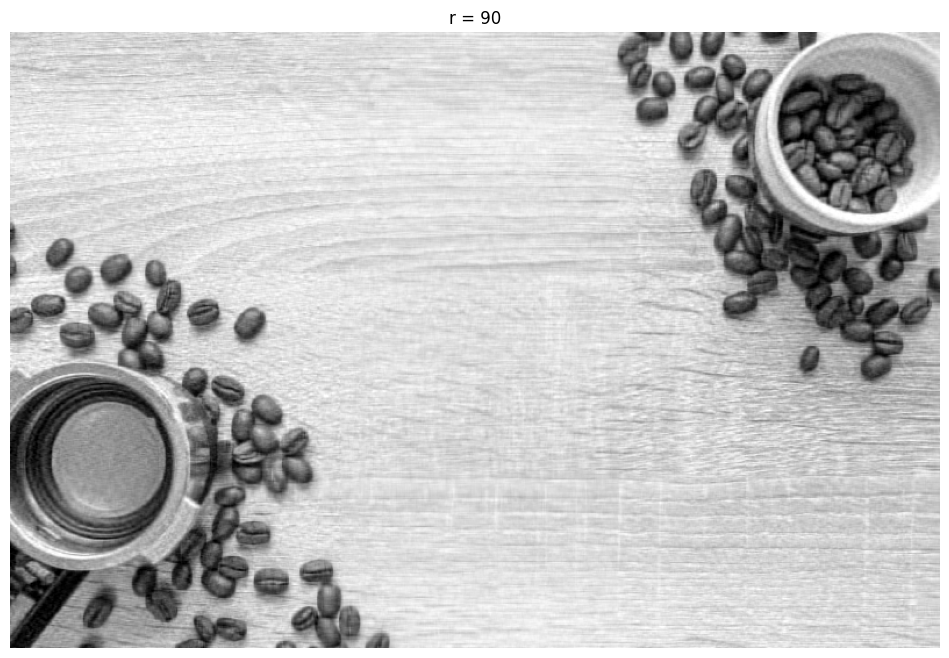

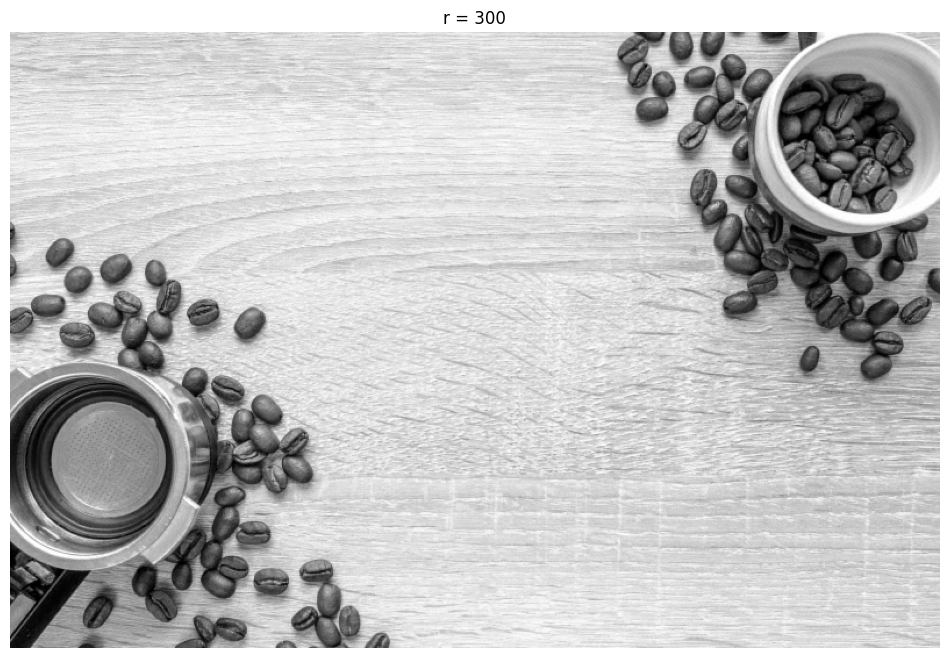

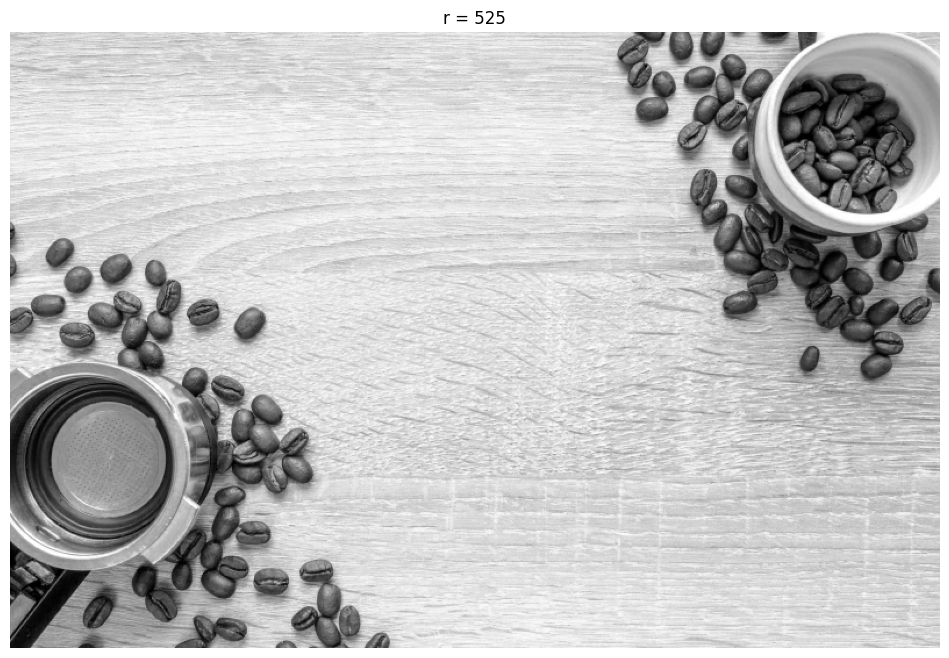

In [28]:

# Load and convert image to grayscale
im = Image.open("12.webp").convert("L")
X = np.array(im, dtype=float)

# Perform SVD
U, S, VT = np.linalg.svd(X, full_matrices=False)
print("Shape of S:", S.shape)

# Convert singular values to diagonal form
S_diag = np.diag(S)

# Reconstruction for different ranks
# 300 - most optimal
r_values = [90, 300, 525]

for j, r in enumerate(r_values, start=1):
    # Approximate reconstruction
    Xapprox = U[:, :r] @ S_diag[:r, :r] @ VT[:r, :]

    # Clip to valid range and show
    Xapprox = np.clip(Xapprox, 0, 255)

    plt.figure(j)
    plt.imshow(Xapprox, cmap="gray")
    plt.axis("off")
    plt.title(f"r = {r}")
    plt.show()


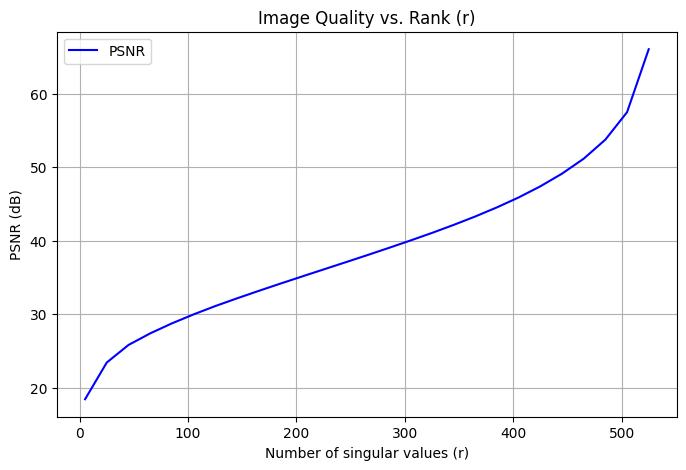

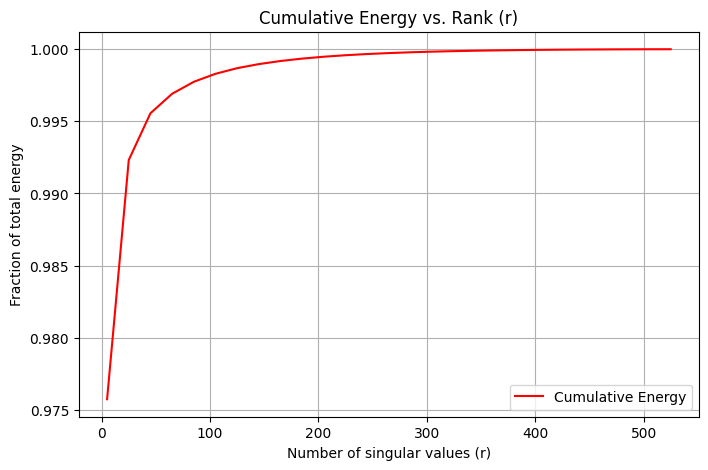

Najlepsza wartość r: 525
z grafu widzimy, że optymalną wartością R jest liczba >=300


In [ ]:
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float("inf")
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))


# Load image and convert to grayscale
im = Image.open("12.webp").convert("L")
X = np.array(im, dtype=float)

# Perform SVD
U, S, VT = np.linalg.svd(X, full_matrices=False)
S_diag = np.diag(S)

# Range of r values to test
r_values = np.arange(5, min(X.shape), 20)
psnr_values = []
energy_ratios = []

total_energy = np.sum(S**2)

# Compute PSNR for each r
for r in r_values:
    Xapprox = U[:, :r] @ S_diag[:r, :r] @ VT[:r, :]
    Xapprox = np.clip(Xapprox, 0, 255)
    psnr_val = psnr(X, Xapprox)
    psnr_values.append(psnr_val)
    energy_ratios.append(np.sum(S[:r] ** 2) / total_energy)

# Plot PSNR vs number of singular values
plt.figure(figsize=(8, 5))
plt.plot(r_values, psnr_values, "b-", label="PSNR")
plt.xlabel("Number of singular values (r)")
plt.ylabel("PSNR (dB)")
plt.title("Image Quality vs. Rank (r)")
plt.grid(True)
plt.legend()
plt.show()

# Plot cumulative energy
plt.figure(figsize=(8, 5))
plt.plot(r_values, energy_ratios, "r-", label="Cumulative Energy")
plt.xlabel("Number of singular values (r)")
plt.ylabel("Fraction of total energy")
plt.title("Cumulative Energy vs. Rank (r)")
plt.grid(True)
plt.legend()
plt.show()

differences = np.diff(psnr_values)
threshold = 0.05  
best_index = np.where(differences < threshold)[0]
if len(best_index) > 0:
    best_r = r_values[best_index[0]]
else:
    best_r = r_values[-1]

print(f"Najlepsza wartość r: {best_r}")
print("z grafów widzimy, że optymalną wartością R jest liczba >=300")
